# Digital Education & Learning analytics - Project part. 2

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.neighbors import KNeighborsRegressor

%matplotlib inline

## Import data

In [2]:
df = pd.read_csv('OutputTable.csv')
df.fillna(0, inplace=True)
df.query('SubmissionNumber > 0', inplace=True)
df['NVideoAndForum'] = df['NVideoEvents'].add(df['NForumEvents'])
df.head()
df.columns

Index(['ProblemID', 'UserID', 'SubmissionNumber', 'TimeStamp', 'TimeSinceLast',
       'Grade', 'GradeDiff', 'NVideoEvents', 'NForumEvents', 'NumberOfPosts',
       'TimeSpentOnForum', 'DurationOfVideoActivity', 'RewatchingScore',
       'NumberOfThreadCreated', 'LastVideoEvent', 'NumberVideoWatched',
       'NumberOfSlowPlay', 'NumberOfThreadViews', 'LastForumEvent',
       'NumberOfVideoInteractions', 'AverageVideoTimeDiffs', 'NumberOfUpvotes',
       'NVideoAndForum'],
      dtype='object')

## aggregation function
The following function aggregates the database by grouping entries by UserID and ProblemID and do the relevant features aggregations.

In [79]:
def aggregate_df(df):
    aggregations = {
        'SubmissionNumber':{
            'TotalNumberOfSubmissions': 'last'
        },
        'TimeSinceLast':{
            'log_AvgTimeBwSubs': lambda x: np.log(np.mean(x))
        },
        'Grade':{ 
            'GradeDiff': lambda x: x.iloc[-1] - x.iloc[0] if len(x) > 1 else x.iloc[0]
        },
        'NVideoEvents':{
            #'NVideoEvents': 'sum',
            'log_NVideoEvents': lambda x: np.log(np.sum(x)+1)
        },    
        'NForumEvents':{
            'NForumEvents': 'sum',
            'log_NForumEvents': lambda x: np.log(np.sum(x)+1)
        },
        'NumberOfPosts':{
            'NumberOfPosts': 'sum'
        },
        'TimeSpentOnForum':{
            'log_TimeSpentOnForum': lambda x: np.log(np.sum(x)+1)
        },
        'DurationOfVideoActivity':{
            'DurationOfVideoActivity': 'sum'
        },
        'RewatchingScore':{
            'RewatchingScore': 'sum'
        },
        'NumberOfThreadCreated':{
            'NumberOfThreadCreated': 'sum'
        },
        'NumberVideoWatched':{
            'NumberVideoWatched': 'sum'
        },
        'NumberOfThreadViews':{
            'NumberOfThreadViews': 'sum'
        },
        'NumberOfVideoInteractions':{
            'NumberOfVideoInteractions': 'sum'
        },
        'NumberOfUpvotes':{
            'NumberOfUpvotes': 'sum'
        },
        'NVideoAndForum': {
            #'TotalNVideoAndForum': 'sum',
            'log_TotalNVideoAndFom': lambda x: np.log(np.sum(x)+1),
            'ActivityRate': lambda x: np.sum(x !=0) / len(x)
        }
    }
    data = df.groupby(by=['UserID', 'ProblemID'], as_index=True).agg(aggregations)
    data.columns = data.columns.droplevel()
    #data.query('TotalNumberOfSubmissions > 1', inplace=True)
    #data.query('TotalNVideoAndForum > 0', inplace=True)
    return data

## Plot the learning curve to assess if models overfit/ underfit (taken from sklearn)

In [152]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=rmse)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best");
    return plt

## Aggregate training data

In [140]:
data = aggregate_df(df)
data.head()

log_NVideoEvents  \
UserID                           ProblemID                     
0009e7ff2e6bad5d80640eeb61cd6e0d 1                       0.0   
                                 3                       0.0   
                                 4                       0.0   
                                 5                       0.0   
                                 8                       0.0   

                                            NumberVideoWatched  \
UserID                           ProblemID                       
0009e7ff2e6bad5d80640eeb61cd6e0d 1                         0.0   
                                 3                         0.0   
                                 4                         0.0   
                                 5                         0.0   
                                 8                         0.0   

                                            TotalNumberOfSubmissions  \
UserID                           ProblemID                             
0009e7ff2e6bad5d80640eeb61cd6e0d 1                                 2   
                                 3                                 1   
                                 4                                 2   
                                 5                                 3   
                                 8                                 1   

                                            DurationOfVideoActivity  \
UserID                           ProblemID                            
0009e7ff2e6bad5d80640eeb61cd6e0d 1                              0.0   
                                 3                              0.0   
                                 4                              0.0   
                                 5                              0.0   
                                 8                              0.0   

                                            log_AvgTimeBwSubs  NForumEvents  \
UserID                           ProblemID                                    
0009e7ff2e6bad5d80640eeb61cd6e0d 1                   4.595120           0.0   
                                 3                   5.552960           0.0   
                                 4                   4.276666           0.0   
                                 5                   5.034786           0.0   
                                 8                   4.158883           0.0   

                                            log_NForumEvents  \
UserID                           ProblemID                     
0009e7ff2e6bad5d80640eeb61cd6e0d 1                       0.0   
                                 3                       0.0   
                                 4                       0.0   
                                 5                       0.0   
                                 8                       0.0   

                                            log_TimeSpentOnForum  \
UserID                           ProblemID                         
0009e7ff2e6bad5d80640eeb61cd6e0d 1                           0.0   
                                 3                           0.0   
                                 4                           0.0   
                                 5                           0.0   
                                 8                           0.0   

                                            NumberOfPosts  \
UserID                           ProblemID                  
0009e7ff2e6bad5d80640eeb61cd6e0d 1                    0.0   
                                 3                    0.0   
                                 4                    0.0   
                                 5                    0.0   
                                 8                    0.0   

                                            NumberOfThreadViews  \
UserID                           ProblemID                        
0009e7ff2e6bad5d80640eeb61cd6e0d 1                          0.0   
                    

In [141]:
# we add several features based on other statistics
data['MeanProblemSubmissionNumber'] = data['TotalNumberOfSubmissions'].groupby(level=1).transform(np.mean)
#data

In [142]:
# convert dataframe in matrix form
y = data.GradeDiff.as_matrix()
X = data.drop('GradeDiff', axis=1).as_matrix()
#X = data.as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

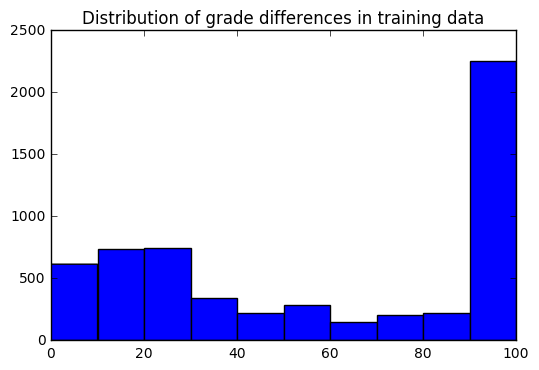

In [143]:
# distribution of training grades
plt.hist(y, bins=10, range=(0,100))
plt.title('Distribution of grade differences in training data');

In [144]:
# wrapper function to be able to use the RMSE as scoring metric in sklearn functions
def rmse_scorer(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
rmse = make_scorer(rmse_scorer)

## linear regression

In [146]:
# there is no hyper paramater to be optimized here, no need for cross validation
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
y_preds = reg.predict(X_test)

In [148]:
results = rmse_scorer(y_test, y_preds)
print('Performance of linear regression:', results)

Performance of linear regression: 39.1050525932


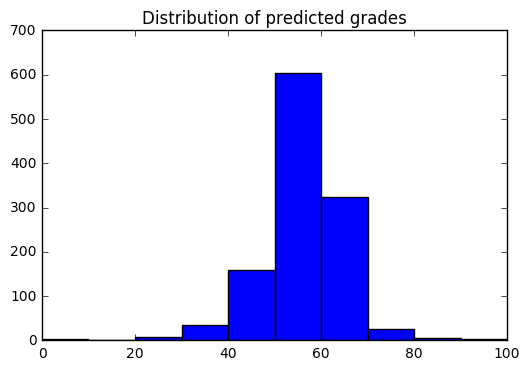

In [157]:
plt.hist(y_preds, bins=10, range=(0,100))
plt.title('Distribution of predicted grades');

## Some observations:
The resulting RMSE on test set is bad. By looking at the distribution of the grades, we can see that the distribution is similar to Gaussian centered at 60, which is the mean obtained grade in the training set. This might indicate under-fitting

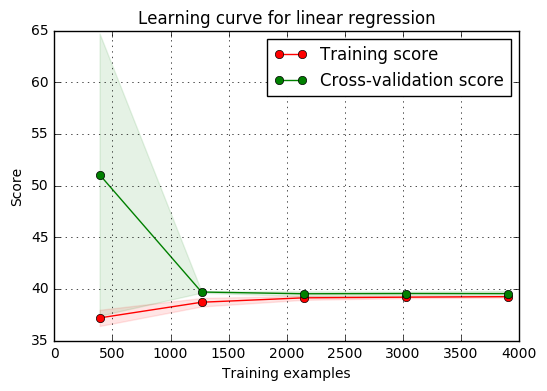

In [155]:
plot_learning_curve(reg, 'Learning curve for linear regression', X, y);

Our first impressions are reinforced by the learning curve plot: training score and cross-validation score are high and close to each other. The model suffers from high bias, we should try a more complex model

## random forest

In [160]:
# try every combination of parameters using grid search Cv
rf = RandomForestRegressor()
param_grid_rf = { 
    'n_estimators': [100, 200, 700],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [1,3,5,7, 10]
}
CV_rf = GridSearchCV(rf, param_grid=param_grid_rf, cv=5, verbose=2, scoring=rmse)
#CV_rf.fit(X, y)

In [158]:
print('best score:', CV_rf.best_score_, '\nwith parameters:', CV_rf.best_params_)

best score: 38.0254590218 
with parameters: {'n_estimators': 100, 'max_depth': 1, 'max_features': 'log2'}


In [166]:
best_rf = RandomForestRegressor(n_estimators=100, max_depth=1, max_features='log2')

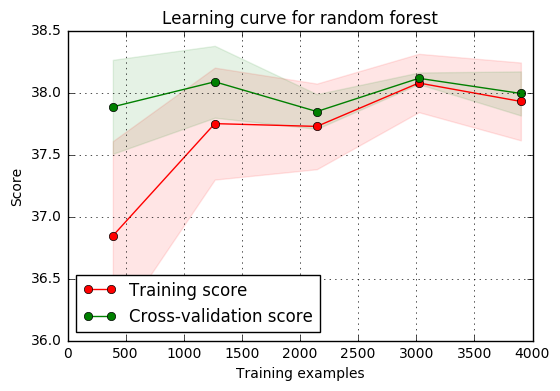

In [167]:
plot_learning_curve(best_rf, 'Learning curve for random forest', X, y);

## MLP regressor

In [169]:
mlp = MLPRegressor()
param_grid_mlp = {
    'learning_rate': ['adaptive'],
    'max_iter': [200],
    'power_t': [0.5],
    'activation': ['logistic'],
    'batch_size': ['auto', 50, 100, 500],
    'early_stopping': [True, False]
}
CV_mlp = GridSearchCV(mlp, param_grid=param_grid_mlp, cv=5, verbose=3, scoring=rmse)
X_scaled = preprocessing.minmax_scale(X)
CV_mlp.fit(X_scaled,y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=True, batch_size=auto 
[CV]  power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=True, batch_size=auto, score=39.606960, total=   2.7s
[CV] power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=True, batch_size=auto 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s


[CV]  power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=True, batch_size=auto, score=41.329639, total=   2.9s
[CV] power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=True, batch_size=auto 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.7s remaining:    0.0s
/Users/Thomas/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


[CV]  power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=True, batch_size=auto, score=39.988643, total=   5.0s
[CV] power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=True, batch_size=auto 
[CV]  power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=True, batch_size=auto, score=40.001518, total=   2.2s
[CV] power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=True, batch_size=auto 
[CV]  power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=True, batch_size=auto, score=39.896217, total=   2.3s
[CV] power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=False, batch_size=auto 


/Users/Thomas/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


[CV]  power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=False, batch_size=auto, score=39.206840, total=   4.4s
[CV] power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=False, batch_size=auto 


/Users/Thomas/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


[CV]  power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=False, batch_size=auto, score=40.995728, total=   5.0s
[CV] power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=False, batch_size=auto 


/Users/Thomas/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


[CV]  power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=False, batch_size=auto, score=39.883707, total=   4.5s
[CV] power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=False, batch_size=auto 


/Users/Thomas/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


[CV]  power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=False, batch_size=auto, score=39.617821, total=   4.1s
[CV] power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=False, batch_size=auto 


/Users/Thomas/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


[CV]  power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=False, batch_size=auto, score=39.454884, total=   4.7s
[CV] power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=True, batch_size=50 
[CV]  power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=True, batch_size=50, score=39.681373, total=   1.7s
[CV] power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=True, batch_size=50 
[CV]  power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=True, batch_size=50, score=40.409816, total=   6.1s
[CV] power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=True, batch_size=50 
[CV]  power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=True, batch_size=50, score=39.667273, total=   4.8s
[CV] power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, e

/Users/Thomas/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


[CV]  power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=True, batch_size=100, score=39.657937, total=   5.0s
[CV] power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=True, batch_size=100 
[CV]  power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=True, batch_size=100, score=39.586834, total=   3.4s
[CV] power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=True, batch_size=100 
[CV]  power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=True, batch_size=100, score=39.868444, total=   1.9s
[CV] power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=False, batch_size=100 


/Users/Thomas/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


[CV]  power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=False, batch_size=100, score=38.674597, total=   5.4s
[CV] power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=False, batch_size=100 


/Users/Thomas/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


[CV]  power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=False, batch_size=100, score=40.428016, total=   5.6s
[CV] power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=False, batch_size=100 


/Users/Thomas/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


[CV]  power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=False, batch_size=100, score=39.564481, total=   7.2s
[CV] power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=False, batch_size=100 


/Users/Thomas/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


[CV]  power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=False, batch_size=100, score=39.439333, total=   7.1s
[CV] power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=False, batch_size=100 


/Users/Thomas/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


[CV]  power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=False, batch_size=100, score=39.287091, total=   6.1s
[CV] power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=True, batch_size=500 


/Users/Thomas/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


[CV]  power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=True, batch_size=500, score=39.907665, total=   3.6s
[CV] power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=True, batch_size=500 


/Users/Thomas/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


[CV]  power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=True, batch_size=500, score=41.674580, total=   3.7s
[CV] power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=True, batch_size=500 
[CV]  power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=True, batch_size=500, score=40.833721, total=   1.9s
[CV] power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=True, batch_size=500 


/Users/Thomas/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


[CV]  power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=True, batch_size=500, score=39.981704, total=   3.8s
[CV] power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=True, batch_size=500 
[CV]  power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=True, batch_size=500, score=40.068594, total=   3.2s
[CV] power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=False, batch_size=500 


/Users/Thomas/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


[CV]  power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=False, batch_size=500, score=39.838959, total=   3.7s
[CV] power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=False, batch_size=500 


/Users/Thomas/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


[CV]  power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=False, batch_size=500, score=41.543829, total=   3.0s
[CV] power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=False, batch_size=500 


/Users/Thomas/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


[CV]  power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=False, batch_size=500, score=40.253548, total=   3.7s
[CV] power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=False, batch_size=500 


/Users/Thomas/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


[CV]  power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=False, batch_size=500, score=39.905012, total=   3.8s
[CV] power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=False, batch_size=500 


/Users/Thomas/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  3.0min finished


[CV]  power_t=0.5, max_iter=200, activation=logistic, learning_rate=adaptive, early_stopping=False, batch_size=500, score=39.945515, total=   3.8s


GridSearchCV(cv=5, error_score='raise',
       estimator=MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'power_t': [0.5], 'max_iter': [200], 'activation': ['logistic'], 'learning_rate': ['adaptive'], 'early_stopping': [True, False], 'batch_size': ['auto', 50, 100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(rmse_scorer), verbose=3)

In [170]:
print('best score:', CV_mlp.best_score_, '\nwith parameters:', CV_mlp.best_params_)

best score: 40.4932528063 
with parameters: {'power_t': 0.5, 'max_iter': 200, 'activation': 'logistic', 'learning_rate': 'adaptive', 'early_stopping': True, 'batch_size': 500}


In [171]:
best_mlp = MLPRegressor(power_t=0.5, max_iter=200, activation='logistic', learning_rate='adaptive', early_stopping=True, batch_size=500)

/Users/Thomas/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:357: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/Users/Thomas/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Users/Thomas/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Users/Thomas/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/User

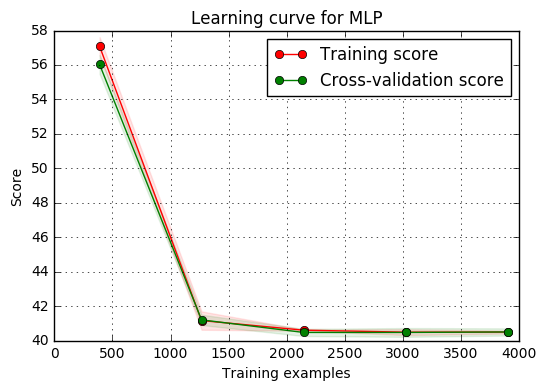

In [172]:
plot_learning_curve(best_mlp, 'Learning curve for MLP', X, y);

## k-nearest neighbors 

In [181]:
knn = KNeighborsRegressor()
param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'leaf_size': [5 ,10, 20, 30, 40, 50]
}
CV_knn = GridSearchCV(knn, param_grid_knn, scoring=rmse, cv=5, verbose=2)
CV_knn.fit(X, y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] leaf_size=5, n_neighbors=3, weights=uniform .....................
[CV] ...... leaf_size=5, n_neighbors=3, weights=uniform, total=   0.1s
[CV] leaf_size=5, n_neighbors=3, weights=uniform .....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ...... leaf_size=5, n_neighbors=3, weights=uniform, total=   0.1s
[CV] leaf_size=5, n_neighbors=3, weights=uniform .....................
[CV] ...... leaf_size=5, n_neighbors=3, weights=uniform, total=   0.1s
[CV] leaf_size=5, n_neighbors=3, weights=uniform .....................
[CV] ...... leaf_size=5, n_neighbors=3, weights=uniform, total=   0.1s
[CV] leaf_size=5, n_neighbors=3, weights=uniform .....................
[CV] ...... leaf_size=5, n_neighbors=3, weights=uniform, total=   0.1s
[CV] leaf_size=5, n_neighbors=3, weights=distance ....................
[CV] ..... leaf_size=5, n_neighbors=3, weights=distance, total=   0.1s
[CV] leaf_size=5, n_neighbors=3, weights=distance ....................
[CV] ..... leaf_size=5, n_neighbors=3, weights=distance, total=   0.1s
[CV] leaf_size=5, n_neighbors=3, weights=distance ....................
[CV] ..... leaf_size=5, n_neighbors=3, weights=distance, total=   0.1s
[CV] leaf_size=5, n_neighbors=3, weights=distance ....................
[CV] .

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   47.6s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'leaf_size': [5, 10, 20, 30, 40, 50], 'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(rmse_scorer), verbose=2)

In [182]:
print('best score:', CV_knn.best_score_, '\nwith parameters:', CV_knn.best_params_)

best score: 36.5171332432 
with parameters: {'leaf_size': 5, 'n_neighbors': 3, 'weights': 'distance'}


In [183]:
best_knn = KNeighborsRegressor(leaf_size=5, n_neighbors=3, weights='distance')

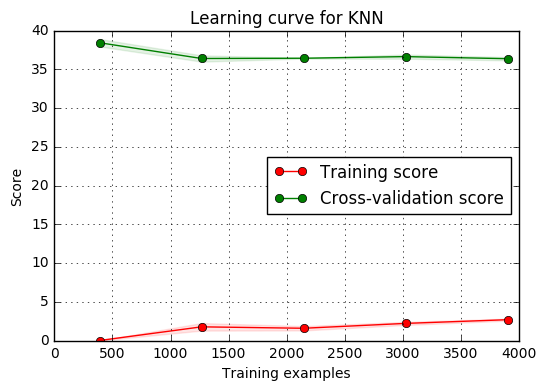

In [184]:
plot_learning_curve(best_knn, 'Learning curve for KNN', X, y);

From this plot we can see that KNN is clearly overfitting, we should increase the number of neighbors to reduce the model complexity

In [188]:
knn2 = KNeighborsRegressor()
param_grid_knn2 = {
    'n_neighbors': [10, 11, 12],
    'weights': ['uniform', 'distance'],
    'leaf_size': [2, 5 ,10]
}
CV_knn2 = GridSearchCV(knn, param_grid_knn2, scoring=rmse, cv=5, verbose=2)
CV_knn2.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] leaf_size=2, n_neighbors=10, weights=uniform ....................
[CV] ..... leaf_size=2, n_neighbors=10, weights=uniform, total=   0.1s
[CV] leaf_size=2, n_neighbors=10, weights=uniform ....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] ..... leaf_size=2, n_neighbors=10, weights=uniform, total=   0.1s
[CV] leaf_size=2, n_neighbors=10, weights=uniform ....................
[CV] ..... leaf_size=2, n_neighbors=10, weights=uniform, total=   0.1s
[CV] leaf_size=2, n_neighbors=10, weights=uniform ....................
[CV] ..... leaf_size=2, n_neighbors=10, weights=uniform, total=   0.1s
[CV] leaf_size=2, n_neighbors=10, weights=uniform ....................
[CV] ..... leaf_size=2, n_neighbors=10, weights=uniform, total=   0.1s
[CV] leaf_size=2, n_neighbors=10, weights=distance ...................
[CV] .... leaf_size=2, n_neighbors=10, weights=distance, total=   0.1s
[CV] leaf_size=2, n_neighbors=10, weights=distance ...................
[CV] .... leaf_size=2, n_neighbors=10, weights=distance, total=   0.1s
[CV] leaf_size=2, n_neighbors=10, weights=distance ...................
[CV] .... leaf_size=2, n_neighbors=10, weights=distance, total=   0.2s
[CV] leaf_size=2, n_neighbors=10, weights=distance ...................
[CV] .

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   35.6s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'leaf_size': [2, 5, 10], 'n_neighbors': [10, 11, 12], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(rmse_scorer), verbose=2)

In [189]:
print('best score:', CV_knn2.best_score_, '\nwith parameters:', CV_knn2.best_params_)

best score: 33.8769185425 
with parameters: {'leaf_size': 10, 'n_neighbors': 10, 'weights': 'distance'}


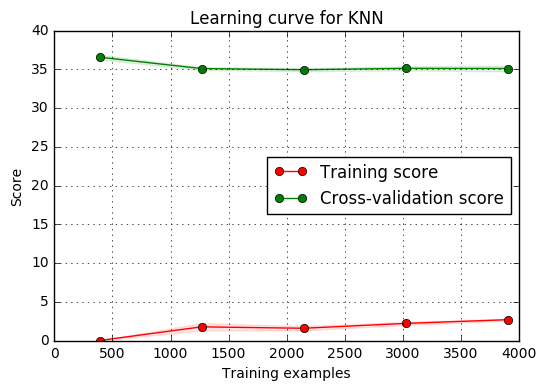

In [190]:
best_knn2 = KNeighborsRegressor(leaf_size=10, n_neighbors=5, weights='distance')
plot_learning_curve(best_knn2, 'Learning curve for KNN', X, y);

## Import test data

In [191]:
test_df = pd.read_csv('OutputTable_test.csv')
test_df.fillna(0, inplace=True)
test_df.query('SubmissionNumber > 0', inplace=True)
test_df['NVideoAndForum'] = test_df['NVideoEvents'].add(test_df['NForumEvents'])

In [195]:
test_data = aggregate_df(test_df)
test_data['MeanProblemSubmissionNumber'] = test_data['TotalNumberOfSubmissions'].groupby(level=1).transform(np.mean)

test_data.head()

log_NVideoEvents  \
UserID                           ProblemID                     
000143a7618ac9cae91b0bf7d059c1fd 4                  0.000000   
                                 5                  0.000000   
                                 6                  0.000000   
                                 7                  0.000000   
0019bbc70f71e4620273237a1e99bfde 1                  5.283204   

                                            NumberVideoWatched  \
UserID                           ProblemID                       
000143a7618ac9cae91b0bf7d059c1fd 4                         0.0   
                                 5                         0.0   
                                 6                         0.0   
                                 7                         0.0   
0019bbc70f71e4620273237a1e99bfde 1                        14.0   

                                            TotalNumberOfSubmissions  \
UserID                           ProblemID                             
000143a7618ac9cae91b0bf7d059c1fd 4                                 2   
                                 5                                13   
                                 6                                 2   
                                 7                                 2   
0019bbc70f71e4620273237a1e99bfde 1                                 2   

                                            DurationOfVideoActivity  \
UserID                           ProblemID                            
000143a7618ac9cae91b0bf7d059c1fd 4                              0.0   
                                 5                              0.0   
                                 6                              0.0   
                                 7                              0.0   
0019bbc70f71e4620273237a1e99bfde 1                         977978.0   

                                            log_AvgTimeBwSubs  NForumEvents  \
UserID                           ProblemID                                    
000143a7618ac9cae91b0bf7d059c1fd 4                   5.209486           0.0   
                                 5                   8.222636           0.0   
                                 6                   6.791783           0.0   
                                 7                   6.280396           0.0   
0019bbc70f71e4620273237a1e99bfde 1                  13.336700           0.0   

                                            log_NForumEvents  \
UserID                           ProblemID                     
000143a7618ac9cae91b0bf7d059c1fd 4                       0.0   
                                 5                       0.0   
                                 6                       0.0   
                                 7                       0.0   
0019bbc70f71e4620273237a1e99bfde 1                       0.0   

                                            log_TimeSpentOnForum  \
UserID                           ProblemID                         
000143a7618ac9cae91b0bf7d059c1fd 4                           0.0   
                                 5                           0.0   
                                 6                           0.0   
                                 7                           0.0   
0019bbc70f71e4620273237a1e99bfde 1                           0.0   

                                            NumberOfPosts  \
UserID                           ProblemID                  
000143a7618ac9cae91b0bf7d059c1fd 4                    0.0   
                                 5                    0.0   
                                 6                    0.0   
                                 7                    0.0   
0019bbc70f71e4620273237a1e99bfde 1                    0.0   

                                            NumberOfThreadViews  \
UserID                           ProblemID                        
000143a7618ac9cae91b0bf7d059c1fd 4                          0.0   
                    

In [196]:
X_test = test_data.drop('GradeDiff', axis=1).as_matrix()
best_model = CV_knn2
preds = best_model.predict(X_test)

In [198]:
test_data['OveralGradeDiff'] = preds
test_data[test_data['OveralGradeDiff'] > 100] = 100
test_data[test_data['OveralGradeDiff'] < 0] = 0
test_data.reset_index(inplace=True)
test_data['uniqRowID'] = test_data.UserID.astype(str) + '_' + test_data.ProblemID.astype(str)

In [199]:
classifier_template = pd.read_csv('data/regression_template.csv')
kaggle_submission = pd.merge(test_data, classifier_template, on='uniqRowID')
kaggle_submission = kaggle_submission[['uniqRowID', 'OveralGradeDiff']]

In [200]:
kaggle_submission.shape

(3767, 2)

In [201]:
kaggle_submission.to_csv('data/regression_results.csv', index=False)